In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/question-pairs-dataset/questions.csv


# 1. Question 1: Vector Embeddings

## 1.1 Data Setup

In [3]:
#Load the Quora Question Pairs dataset
df = pd.read_csv("/kaggle/input/question-pairs-dataset/questions.csv")

In [4]:
#view the first few records
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
#Handle the missing data by dropping the NaN values in Question1 and Question2
df = df.dropna(subset=["question1", "question2"])

## 1.2 Text Preprocessing & Embedding

### 1. Preprocessing:
- Preprocess your data with whichever methods you deem fit for cleaning text

In [7]:
import re
def preporcessing(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply preprocessing
df["question1"] = df["question1"].apply(preporcessing)
df["question2"] = df["question2"].apply(preporcessing)

In [8]:
#After preprocessing
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...,0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


### 2. Choose an Embedding Method:
- You may use pretrained embeddings (e.g., GloVe, Tf-idf, fastText, etc.) via gensim or any other
library

In [9]:
import gensim.downloader as api
from gensim.models import KeyedVectors
import numpy as np


In [10]:
# Load pretrained GloVe embeddings
print("Loading pre-trained Glove embeddings")
glove_vectors = api.load("glove-wiki-gigaword-50")
print("Model Loaded successfully")

Loading pre-trained Glove embeddings
[==================================================] 100.0% 66.0/66.0MB downloaded
Model Loaded successfully


### 3. Vector Representation:
- For each question (you can combine question1 and question2 into one combined column, or continue
to treat them separately), embed the question into a vector.
- Construct a matrix (num questions, embedding dimension) representing all the questions

In [11]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def get_sentence_embedding(sentence, model):
    words = word_tokenize(sentence)  # More robust tokenization
    word_vectors = [model[word] for word in words if word in model]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        
        return np.zeros(model.vector_size)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
# Combine questions into a single column
df["combined_question"] = df["question1"] + " " + df["question2"]

In [13]:
# Generate embeddings for combined questions
df["combined_embedding"] = df["combined_question"].apply(lambda x: get_sentence_embedding(x, glove_vectors))

In [14]:
# Construct embedding matrix
embedding_matrix = np.vstack(df["combined_embedding"].values)

# Display sample results
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (404348, 50)


In [15]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,combined_question,combined_embedding
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,"[0.42206758, 0.030950079, 0.04003307, 0.052157..."
1,1,3,4,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0,what is the story of kohinoor kohinoor diamond...,"[0.16032724, 0.052564774, -0.21682666, 0.15706..."
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,how can i increase the speed of my internet co...,"[0.431272, 0.06882063, 0.42122915, 0.0619536, ..."
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...,0,why am i mentally very lonely how can i solve ...,"[0.47216088, -0.022894742, 0.02107759, -0.2982..."
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,which one dissolve in water quikly sugar salt ...,"[0.45246294, 0.21187137, -0.13217072, 0.040367..."


## 1.3 Cosine Similarity and Nearest Neighbors


### 1. Choose 5 “query” questions from your dataset.


In [16]:
# Choose 5 query questions (random selection or manual selection)
query_indices = np.random.choice(len(df), 5, replace=False)
query_embeddings = embedding_matrix[query_indices]
query_questions = df.iloc[query_indices]["combined_question"].values
print(query_questions)

['how do i launch your product successfully to the market how do you launch a new product successfully'
 'my iphone 6 broke how can i quickly replace it can i use gestures on iphone 6 plus to quickly hide what im doing'
 'what is the difference between research paper and research article what are the differences between a journal article and a research working paper'
 'when i say croatia you think of im visiting croatia czech republic slovenia and austria what are the places i should visit what are the things i should carry'
 'is a backpack considered by the airlines as luggage or a personal item when traveling on an airplane why do airlines lose your luggage all the time']


### 2. For each query question, compute cosine similarity between its vector embedding and the embedding of every other question in the dataset.


In [17]:
from sklearn.metrics.pairwise import cosine_similarity

In [18]:
# Compute cosine similarity between query embeddings and all embeddings
similarity_matrix = cosine_similarity(query_embeddings, embedding_matrix)
print(similarity_matrix)

[[0.94902784 0.89822775 0.95085114 ... 0.8849781  0.9538865  0.9416276 ]
 [0.90737    0.8703186  0.9463661  ... 0.86825234 0.94459933 0.9438289 ]
 [0.9280121  0.87379247 0.9092968  ... 0.8425474  0.93784803 0.903585  ]
 [0.91087306 0.8924812  0.87587976 ... 0.85419667 0.93411696 0.9273428 ]
 [0.9183257  0.89738876 0.9371322  ... 0.88515276 0.94595754 0.94132924]]


### 3. Retrieve the top-5 most similar questions for each query question, based on cosine similarity.


In [19]:
# Retrieve top-5 most similar questions for each query
for i, query in enumerate(query_questions):
    similar_indices = np.argsort(similarity_matrix[i])[::-1][1:6]  # Exclude self-match (highest score)
    similar_questions = df.iloc[similar_indices]["combined_question"].values
    print(f"Query {i+1}: {query}")
    print("Top 5 Similar Questions:")
    for j, sim_q in enumerate(similar_questions):
        print(f"{j+1}. {sim_q}")
    print("-" * 80)

Query 1: how do i launch your product successfully to the market how do you launch a new product successfully
Top 5 Similar Questions:
1. how do you successfully launch a product i want to launch a new product where can i launch my product to get good reach
2. what is the best way to research and evaluate your competitors on amazon i am opening a startup and i want to do digital marketing for it how soon do i do digital marketing before launch
3. how do you start a technology company what does it take to start a technology company
4. how do i work on multiple startup ideas if you have an idea for a startup how can you make market research so your ideaproduct will work does the market need that product or service
5. what are the things to do just after creating a blogspot blog if your business is just creating a sales enablement function what do you believe are the first things a sales enablement manager should do to build capability quickly
---------------------------------------------

### 4. Discuss whether these nearest neighbors make sense. Are they semantically similar or related in any obvious way?

- The embeddings do a reasonable job of capturing broad topical similarities but struggle with fine-grained semantic distinctions.
- Queries about widely discussed topics (e.g., education, Quora ranking) return better matches than niche topics (e.g., business ideas, astrologers).
- Some irrelevant matches likely arise due to token-based similarity rather than true semantic understanding.
- 
### Let's see the queries

#### Query 1: Social Media Experts

- The retrieved questions are somewhat relevant, as they discuss social media marketing, tools, and agencies.
- However, some results are loosely connected, such as discussions about social media campaigns rather than experts specifically.
- The model does capture some level of topical similarity, but it's not perfectly refined.
#### Query 2: Technology & Education

- The top three retrieved questions are highly relevant, as they directly address how technology impacts education.
- The last two results diverge slightly into social development and computer education, which are related but not exact matches.
- Overall, this set of nearest neighbors demonstrates strong semantic similarity.
#### Query 3: Quora Ranking System

- Some retrieved questions are related to Quora, answer ranking, and responses, which align well with the query.
- Others (e.g., job interview questions) deviate significantly, suggesting the model is picking up on general themes of ranking or responses rather than the specific context of Quora.


# Question 2: Neural Networks

## 2.1 Data Preparation & Splitting

### 1. Keep the original structure of the dataset

In [20]:
df_new = df[['question1', 'question2', 'is_duplicate']]
df_new.head()

,question1,question2,is_duplicate
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...,0
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


### 2. Construct your feature vectors:
- Use the same embeddings you created in Question 1. For each question, you have a vector;
- you can then concatenate (or subtract, or otherwise combine) the embeddings of question1 and question2

In [21]:
# Generate embeddings for each question using the embedding used in question 1
df_new.loc[:, 'q1_vector'] = df_new['question1'].apply(lambda x: get_sentence_embedding(x, glove_vectors))
df_new.loc[:, 'q2_vector'] = df_new['question2'].apply(lambda x: get_sentence_embedding(x, glove_vectors))

# Function to combine embeddings using three strategies
def combine_embeddings(row):
    q1_vec = row['q1_vector']
    q2_vec = row['q2_vector']
    
    concatenation = np.concatenate((q1_vec, q2_vec))  # [q1, q2]
    subtraction = np.abs(q1_vec - q2_vec)             # [q1 - q2]
    multiplication = q1_vec * q2_vec                  # [q1 * q2]
    
    return np.concatenate((concatenation, subtraction, multiplication))  # Final combined vector

# Apply feature combination
df_new['combined_vector'] = df_new.apply(combine_embeddings, axis=1)

# Convert list of arrays into a 2D NumPy array for model training
X = np.stack(df_new['combined_vector'].values)  # Feature matrix
y = df_new['is_duplicate'].values  # Labels

# Print shape of final dataset
print(f"Feature Vector Shape: {X.shape}")  
print(f"Label Vector Shape: {y.shape}")

<ipython-input-21-5eafef109ca1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.loc[:, 'q1_vector'] = df_new['question1'].apply(lambda x: get_sentence_embedding(x, glove_vectors))
<ipython-input-21-5eafef109ca1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.loc[:, 'q2_vector'] = df_new['question2'].apply(lambda x: get_sentence_embedding(x, glove_vectors))
<ipython-input-21-5eafef109ca1>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Feature Vector Shape: (404348, 200)
Label Vector Shape: (404348,)


### 3. Split your dataset into train, validation, and test sets. A typical split might be 80%–10%–10%, bu you may adjust as needed

In [22]:
from sklearn.model_selection import train_test_split

# Split the dataset (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset shapes
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")

Training Set: (323478, 200), Validation Set: (40435, 200), Test Set: (40435, 200)


## 2.2 Custom Neural Network

### 1. Architecture

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [25]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Print dataset shapes
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")

Training Set: (323478, 200), Validation Set: (40435, 200), Test Set: (40435, 200)


In [26]:
batch_size = 64  # Define batch size

# Create DataLoader objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [27]:
class DuplicateQuestionClassifier(nn.Module):
    def __init__(self, input_dim):
        super(DuplicateQuestionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)  # First hidden layer
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(256, 128)  # Second hidden layer
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(128, 1)  # Output layer
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary classification
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [28]:
# Initialize model
input_dim = X_train.shape[1]  # Feature vector size
model = DuplicateQuestionClassifier(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


DuplicateQuestionClassifier(
  (fc1): Linear(in_features=200, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### 2. Hyperparameters and training

In [29]:
# Hyperparameters
learning_rate = 0.001
batch_size = 64
num_epochs = 10

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [31]:
# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move to GPU if available
        
        optimizer.zero_grad()  # Reset gradients
        outputs = model(batch_X)  # Forward pass
        loss = criterion(outputs, batch_y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

    # Print training loss
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

Epoch [1/10], Training Loss: 0.4596
Epoch [2/10], Training Loss: 0.4578
Epoch [3/10], Training Loss: 0.4553
Epoch [4/10], Training Loss: 0.4526
Epoch [5/10], Training Loss: 0.4515
Epoch [6/10], Training Loss: 0.4491
Epoch [7/10], Training Loss: 0.4481
Epoch [8/10], Training Loss: 0.4466
Epoch [9/10], Training Loss: 0.4448
Epoch [10/10], Training Loss: 0.4435


## 2.3 Evaluation

### 1. Evaluate your model on the validation set during training to tune hyperparameters (e.g., pick the epoch with the best validation accuracy or lowest validation loss)

In [33]:
best_val_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    
    # Store the best model (lowest validation loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Load the best model state after training
model.load_state_dict(best_model_state)


Epoch [1/10], Training Loss: 0.4370, Validation Loss: 0.4409
Epoch [2/10], Training Loss: 0.4358, Validation Loss: 0.4401
Epoch [3/10], Training Loss: 0.4352, Validation Loss: 0.4413
Epoch [4/10], Training Loss: 0.4340, Validation Loss: 0.4407
Epoch [5/10], Training Loss: 0.4324, Validation Loss: 0.4405
Epoch [6/10], Training Loss: 0.4311, Validation Loss: 0.4391
Epoch [7/10], Training Loss: 0.4313, Validation Loss: 0.4418
Epoch [8/10], Training Loss: 0.4296, Validation Loss: 0.4389
Epoch [9/10], Training Loss: 0.4290, Validation Loss: 0.4419
Epoch [10/10], Training Loss: 0.4281, Validation Loss: 0.4388


<All keys matched successfully>

Test Accuracy: 0.7798
Precision: 0.6967
Recall: 0.7070
F1-score: 0.7018


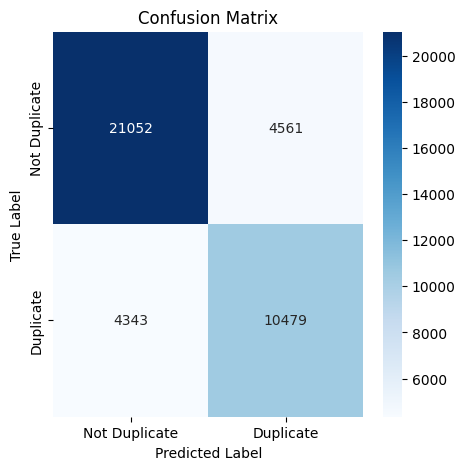

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            predictions = (outputs > 0.5).float()  # Convert logits to binary values (0 or 1)
            
            y_true.extend(batch_y.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Duplicate", "Duplicate"], yticklabels=["Not Duplicate", "Duplicate"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate the best model on the test set
evaluate_model(model, test_loader)
